In [1]:
import numpy as np
import os
import skimage
import utils as imgTrans
import fileIO as importFile
import matplotlib.pyplot as plt
import mlUtils as mL

In [2]:
def oneHotEncoding(speciesDic):
    curList = []
    for key in speciesDic:
        curList.append(speciesDic[key])
    speciesSet = set(curList)
    
    newDic = {}
    cnt = 0
    for key in speciesSet:
        newDic[key] = cnt
        cnt = cnt + 1
    return(cnt,newDic)

In [3]:
allFiles = importFile.readFileToDic()
numLabel,oneHotDic = oneHotEncoding(allFiles)

numLayers = 10
numRows = 32
numCols = 32

curPath = '../../data/oryzeae/'

tX = np.empty((numLayers*numCols*numRows))
tY = np.empty((1,numLabel))
vX = np.empty((numLayers*numCols*numRows))
vY = np.empty((1,numLabel))
testX = np.empty((numLayers*numCols*numRows))
testY = np.empty((1,numLabel))

for file in os.listdir(curPath):
    tiffFile = curPath+file
    species = allFiles[file]
    
    im = skimage.io.imread(tiffFile)
    im2 = skimage.transform.resize(im,(numLayers,numRows,numCols),mode='reflect')
    
    tmp = np.ndarray.flatten(im2)
    tX = np.vstack((tX,tmp))
    
    tmp = np.zeros((1,numLabel))
    curLabel = oneHotDic[species]
    tmp[0][curLabel] = 1
    tY = np.vstack((tY,tmp))
    
    allImg = imgTrans.manyRandImg(im2,20)
    for i in allImg:
        randNum = np.random.rand((1))
        tmp = np.ndarray.flatten(i)
        
        if randNum < .8:
            tX = np.vstack((tX,tmp))
            
            tmp = np.zeros((1,numLabel))
            curLabel = oneHotDic[species]
            tmp[0][curLabel] = 1
            tY = np.vstack((tY,tmp))
        elif randNum < .9:
            vX = np.vstack((vX,tmp))
            
            tmp = np.zeros((1,numLabel))
            curLabel = oneHotDic[species]
            tmp[0][curLabel] = 1
            vY = np.vstack((vY,tmp))
        else:
            testX = np.vstack((testX,tmp))
            
            tmp = np.zeros((1,numLabel))
            curLabel = oneHotDic[species]
            tmp[0][curLabel] = 1
            testY = np.vstack((testY,tmp))

In [4]:
tX = np.delete(tX, (0), axis=0)
tY = np.delete(tY, (0), axis=0)
vX = np.delete(vX, (0), axis=0)
vY = np.delete(vY, (0), axis=0)
testX = np.delete(testX, (0), axis=0)
testY = np.delete(testY, (0), axis=0)

In [5]:
linReg = mL.linear()
wHat = linReg.train(tX,tY,.1)

In [6]:
Y_hat = linReg.predict(wHat, tX)
print("train: "+str(mL.accuracy(tY, Y_hat)))

Y_hat = linReg.predict(wHat, vX)
print("validation: "+str(mL.accuracy(vY, Y_hat)))

Y_hat = linReg.predict(wHat, testX)
print("test: "+str(mL.accuracy(testY, Y_hat)))

train: 0.999038461538
validation: 0.779661016949
test: 0.756097560976


In [7]:
#logistic regression
logReg = mL.logistic()

In [42]:
step_size = 0.001
lam = 0.01
eps = 0.00001
maxiter = 1000

In [43]:
outputList = []
print(len(tY[0]))
for i in range(0,len(tY[0])):
    newtY = mL.oneHotToLogLabels(tY,i)
    newtestY = mL.oneHotToLogLabels(testY,i)

    output = logReg.reg_gradient_desc(tX, newtY, testX, newtestY, step_size, lam, eps, maxiter)
    outputList.append(output)

6
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached


In [112]:
yVAll = np.zeros((testX.shape[0],len(tY[0])))
yVAll = np.zeros((tX.shape[0],len(tY[0])))
for i in range(0,len(output)):
    curOutput = outputList[i]
    W = curOutput[0] #weights
    b = curOutput[1] #offsets

    yHat = b + tX.dot(W)
    yVAll[:,i] = yHat[:,0]
    
tmp = np.argmax(yVAll,axis=1)
#print(tmp)
#for i in range(0,len(tmp)):
#    print(tmp[i])
#print(yVAll)   

In [152]:
output = outputList[4]
W = output[0] #weights
b = output[1] #offsets
likelihoods = output[2] #series of likelihoods per gradient descent step
test_likelihoods = output[3] #series of test data likelihoods per gradient descent steps
errs = 1.0 - np.array(output[4]) #series of errors
test_errs = 1.0 - np.array(output[5]) #series of test errors

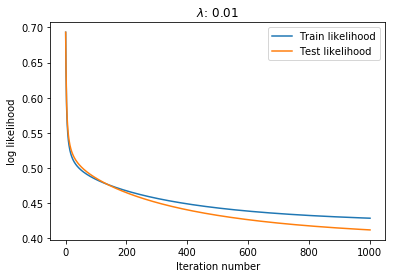

In [136]:
#likelihoods
iters = len(likelihoods)

plt.plot(range(iters), likelihoods, label="Train likelihood")
plt.plot(range(iters), test_likelihoods, label="Test likelihood")
plt.xlabel("Iteration number")
plt.ylabel("log likelihood")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

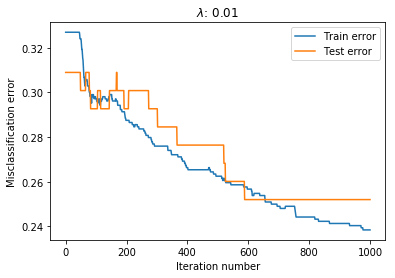

In [153]:
#accuracies
iters = len(errs)

plt.plot(range(iters), errs, label="Train error")
plt.plot(range(iters), test_errs, label="Test error")
plt.xlabel("Iteration number")
plt.ylabel("Misclassification error")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

In [154]:
print(test_errs)

[ 0.30894309  0.30894309  0.30894309 ...,  0.25203252  0.25203252
  0.25203252]


In [140]:
print(oneHotDic)

{'Leersia oryzoides': 0, 'Oryza glabra': 1, 'Oryza barthii': 2, 'Oryza subulata': 3, 'Zizania palustris': 4, 'Zizaniopsis': 5}


In [13]:
#stochastic gradient descent

In [14]:
step_size = 0.01
lam = 0.1
eps = 0.001
maxiter = 100
batch_size = 1

In [15]:
output = logReg.stoch_reg_gradient_desc(tX, newtY, testX, newtestY, step_size, lam, eps, maxiter, batch_size)

maximum iterations reached


In [16]:
W = output[0]
b = output[1]
likelihoods = output[2]
test_likelihoods = output[3]
errs = 1.0 - np.array(output[4])
test_errs = 1.0 - np.array(output[5])

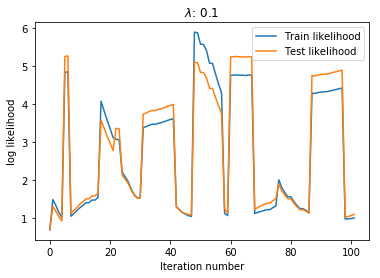

In [17]:
#likelihoods
iters = len(likelihoods)

plt.plot(range(iters), likelihoods, label="Train likelihood")
plt.plot(range(iters), test_likelihoods, label="Test likelihood")
plt.xlabel("Iteration number")
plt.ylabel("log likelihood")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

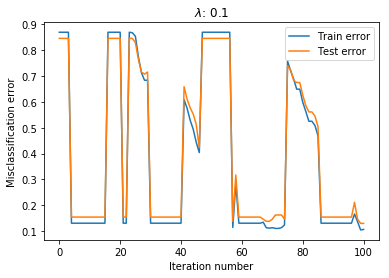

In [18]:
#accuracies
iters = len(errs)

plt.plot(range(iters), errs, label="Train error")
plt.plot(range(iters), test_errs, label="Test error")
plt.xlabel("Iteration number")
plt.ylabel("Misclassification error")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()